# Grupo 3
**Participantes:**<br><br>
Daniel Moreira<br>
Lia Morimoto<br>
Ryan Ferreira<br>
Thiago Figueira

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

from sklearn.cluster import AgglomerativeClustering

In [2]:
# Reading datasets
movies_df = pd.read_csv(r'movies.csv')
ratings_df  = pd.read_csv(r'ratings.csv')

In [3]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# Getting initial info
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB



Let us remove the year from the title column by using pandas' replace function and store in a new year column.

In [5]:
movies_df['year'] = movies_df.title.str.extract('(\(\d\d\d\d\))',expand=False)
#Removing the parentheses
movies_df['year'] = movies_df.year.str.extract('(\d\d\d\d)',expand=False)
#Removing the years from the 'title' column
movies_df['title'] = movies_df.title.str.replace('(\(\d\d\d\d\))', '')
#Applying the strip function to get rid of any ending whitespace characters that may have appeared
movies_df['title'] = movies_df['title'].apply(lambda x: x.strip())
movies_df.head()

<ipython-input-5-3076c6b24e7f>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  movies_df['title'] = movies_df.title.str.replace('(\(\d\d\d\d\))', '')


,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


Let us also split the values in the Genres column into a list of Genres to simplify future use. This can be achieved by applying Python's split string function on the correct column.

In [6]:
#Every genre is separated by a | so we simply have to call the split function on |
movies_df['genres'] = movies_df.genres.str.split('|')
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995


In [7]:
movies_df.shape

(9742, 4)

Since keeping genres in a list format isn't optimal for the content-based recommendation system technique, we will use the One Hot Encoding technique to convert the list of genres to a vector where each column corresponds to one possible value of the feature. This encoding is needed for feeding categorical data. In this case, we store every different genre in columns that contain either 1 or 0. 1 shows that a movie has that genre and 0 shows that it doesn't. Let's also store this dataframe in another variable since genres won't be important for our first recommendation system.

In [8]:
#Copying the movie dataframe into a new one since we won't need to use the genre information in our first case.
moviesWithGenres_df = movies_df.copy()

#For every row in the dataframe, iterate through the list of genres and place a 1 into the corresponding column
for index, row in movies_df.iterrows():
    for genre in row['genres']:
        moviesWithGenres_df.at[index, genre] = 1
#Filling in the NaN values with 0 to show that a movie doesn't have that column's genre
moviesWithGenres_df = moviesWithGenres_df.fillna(0)
moviesWithGenres_df.head()

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II,[Comedy],1995,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let us look at the ratings dataset

In [9]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [10]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


We will drop the timestamp column

In [11]:
#Drop removes a specified row or column from a dataframe
ratings_df = ratings_df.drop('timestamp', 1)
ratings_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


<AxesSubplot:title={'center':'Most common ratings'}>

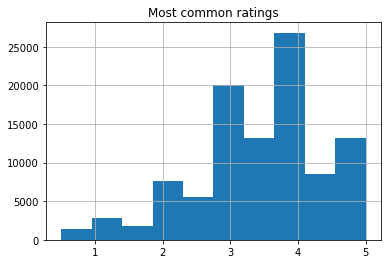

In [12]:
plt.title('Most common ratings')
ratings_df['rating'].hist()

Merging the data from the datasets

In [13]:
df = moviesWithGenres_df.merge(ratings_df, on='movieId')
df.head()

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed),userId,rating
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,4.0
1,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,4.0
2,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,4.5
3,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15,2.5
4,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,4.5


In [14]:
# Getting average rating per film and total number of reviewers
movieProperties = ratings_df.groupby('movieId').agg({'rating': [np.size, np.mean]})
movieProperties.head()

rating          
          size      mean
movieId                 
1        215.0  3.920930
2        110.0  3.431818
3         52.0  3.259615
4          7.0  2.357143
5         49.0  3.071429

In [15]:
# Visualizing shape
movieProperties.shape

(9724, 2)

In [16]:
# Normalizing rating size values
movieNumRatings = pd.DataFrame(movieProperties['rating']['size'])
movieNormalizedNumRatings = movieNumRatings.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
movieNormalizedNumRatings.head()

,size
movieId,
1,0.652439
2,0.332317
3,0.155488
4,0.018293
5,0.146341


In [17]:
# Getting the average rating
averageRatings = pd.DataFrame(movieProperties['rating']['mean'])
averageRatings.head()

,mean
movieId,
1,3.920930
2,3.431818
3,3.259615
4,2.357143
5,3.071429


In [18]:
# Adding new column with the normalized rating values 
df = df.merge(movieNormalizedNumRatings, on='movieId')
df.head()

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed),userId,rating,size
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,4.0,0.652439
1,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,4.0,0.652439
2,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,4.5,0.652439
3,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15,2.5,0.652439
4,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,4.5,0.652439


In [19]:
df = df.merge(averageRatings, on='movieId')
df.head()

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed),userId,rating,size,mean
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,4.0,0.652439,3.92093
1,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5,4.0,0.652439,3.92093
2,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7,4.5,0.652439,3.92093
3,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,15,2.5,0.652439,3.92093
4,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,17,4.5,0.652439,3.92093


In [20]:
df.shape

(100836, 28)

In [21]:
# Checking for null values
df.isnull().sum()

movieId               0
title                 0
genres                0
year                  0
Adventure             0
Animation             0
Children              0
Comedy                0
Fantasy               0
Romance               0
Drama                 0
Action                0
Crime                 0
Thriller              0
Horror                0
Mystery               0
Sci-Fi                0
War                   0
Musical               0
Documentary           0
IMAX                  0
Western               0
Film-Noir             0
(no genres listed)    0
userId                0
rating                0
size                  0
mean                  0
dtype: int64

In [22]:
df1 = df.copy()
df1.drop(['title', 'genres', 'year', 'userId','rating'], axis=1, inplace=True)

In [23]:
df1.head()

,movieId,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,...,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed),size,mean
0,1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.652439,3.92093
1,1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.652439,3.92093
2,1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.652439,3.92093
3,1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.652439,3.92093
4,1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.652439,3.92093


In [24]:
df1 = df1.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)

In [25]:
df1.shape

(9724, 23)

In [26]:
df1.head()

,movieId,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,...,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed),size,mean
0,1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.652439,3.920930
215,2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.332317,3.431818
325,3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.155488,3.259615
377,4,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018293,2.357143
384,5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.146341,3.071429


<AxesSubplot:title={'center':'Mean rating distribution'}>

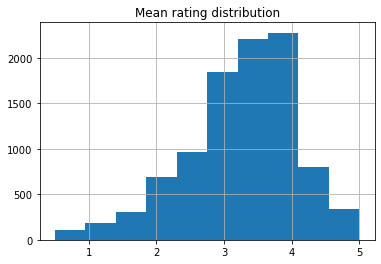

In [27]:
plt.title('Mean rating distribution')
df1['mean'].hist()

In [28]:
# Contagem de filmes de cada gênero
a = []
b = []

for column in df1.drop(['movieId', 'size',	'mean'], axis=1).columns:
  a.append(column)
  b.append(df1[column].sum())

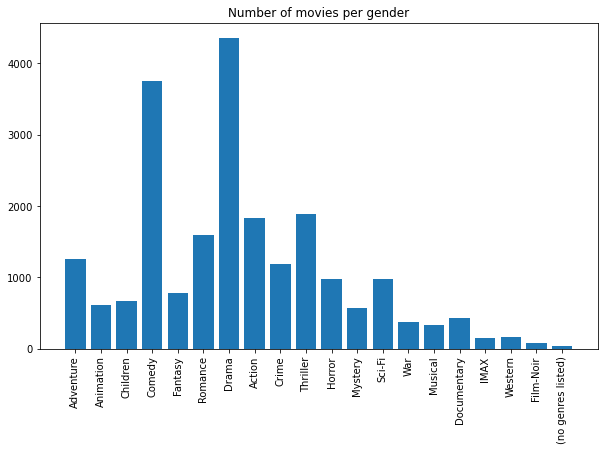

In [29]:
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.title('Number of movies per gender')
plt.bar(x=a, height=b)
plt.show()

In [30]:
#sns.pairplot(df1)

In [31]:
cols= ['movieId', 'mean']
df1_agg = df1.drop(columns=cols, axis=1)

In [32]:
df1_agg.shape

(9724, 21)

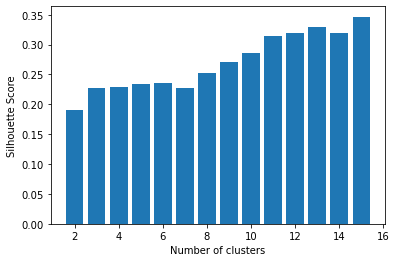

In [33]:
silhouette_scores = [] 

for n_cluster in range(2, 16):
    silhouette_scores.append( 
        silhouette_score(df1_agg, KMeans(n_clusters = n_cluster).fit_predict(df1_agg))) 
    
# Plotting a bar graph to compare the results 
k = [2, 3, 4, 5, 6,7, 8, 9, 10 ,11, 12, 13, 14, 15] 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show() 

In [34]:
kmeans = KMeans(n_clusters=15)
kmeans.fit(df1_agg)

KMeans(n_clusters=15)

In [35]:
hc = AgglomerativeClustering(n_clusters=15, affinity='euclidean', linkage='ward')

# Treinar o modelo e fazer previsão dos clusters
y_predict = hc.fit_predict(df1_agg)

In [36]:
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995


In [37]:
movies_df.shape

(9742, 4)

In [38]:
df1['Cluster_label'] = y_predict

In [39]:
df1.head()

,movieId,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,...,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed),size,mean,Cluster_label
0,1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.652439,3.920930,6
215,2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.332317,3.431818,6
325,3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.155488,3.259615,4
377,4,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018293,2.357143,4
384,5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.146341,3.071429,11


In [40]:
# Criando a função que retorna aleatoriamente 5 filmes do mesmo cluster do filme inserido pelo usuário

def recomendacao(movieId):
    print('Seu filme escolhido foi:')
  #print(movies_df[movies_df['movieId'] == movieId])
    print(f"{movies_df[movies_df['movieId'] == movieId]['movieId'].values[0]} -  " + f"{movies_df[movies_df['movieId'] == movieId]['title'].values[0]} - " + f"{movies_df[movies_df['movieId'] == movieId]['genres'].values[0]}")
    cluster = df1[df1['movieId'] == movieId]['Cluster_label'].values[0]
  #print(cluster)
    select_dataframe = df1[df1['Cluster_label'] == cluster]
    samples = select_dataframe.sample(n = 5, replace = False)
    selected = samples['movieId'].values
    a = []

    print('------------------------------------------')
    print('\n\nBaseado na sua seleção escolhemos: ')

    for s in selected:
        a.append(movies_df[movies_df['movieId'] == s]['title'].values[0])

        print()

        print(f"{movies_df[movies_df['movieId'] == s]['movieId'].values[0]} - " + f"{movies_df[movies_df['movieId'] == s]['title'].values[0]} - "+f"{movies_df[movies_df['movieId'] == s]['genres'].values[0]} ")

        print()

    return a

In [41]:
df1['Cluster_label'].value_counts()

12    1050
11     945
2      840
0      829
8      788
5      764
6      735
3      678
4      637
1      597
10     483
7      397
9      345
13     318
14     318
Name: Cluster_label, dtype: int64

In [42]:
from IPython.display import clear_output

In [54]:
def interface():  
    lista = []

    for i in range(15):
        lista.append(df1[df1['Cluster_label'] == i].sample(n = 1, replace = False)['movieId'].values[0])

    print("Filmenator: diga um filme e te recomendaremos um parecido")
    print('se não gostar de nenhuma recomendação aperte R')
    print()
    print('Id do filme - Nome')
    for item in lista:
        print(f"{movies_df[movies_df['movieId'] == item]['movieId'].values[0]} -  " + f"{movies_df[movies_df['movieId'] == item]['title'].values[0]} - " + f"{movies_df[movies_df['movieId'] == item]['genres'].values[0]}")

    print('\n\nIndique o id do filme escolhido:')
    print('Se preferir indicação de filmes diferentes, basta digitar r:')
    movieId = input('Digite seu ID: ')
    if(movieId == 'r' or movieId == 'R'):
        #os.system('clear')
        clear_output(wait=False)
        interface()
    else:
        movieId = int(movieId)
        print('--------------------------------------------')

        a = recomendacao(movieId)
        print(a)


In [55]:
interface()

Filmenator: diga um filme e te recomendaremos um parecido
se não gostar de nenhuma recomendação aperte R

Id do filme - Nome
143559 -  L.A. Slasher - ['Comedy', 'Crime', 'Fantasy']
2912 -  Limey, The - ['Crime', 'Drama', 'Thriller']
2016 -  Apple Dumpling Gang Rides Again, The - ['Children', 'Comedy', 'Western']
3700 -  Brother from Another Planet, The - ['Drama', 'Sci-Fi']
5135 -  Monsoon Wedding - ['Comedy', 'Romance']
133365 -  Partisan - ['Drama', 'Thriller']
8713 -  New Adventures of Pippi Longstocking, The - ['Adventure', 'Children', 'Fantasy', 'Musical']
127164 -  What Happened, Miss Simone? - ['Documentary']
84799 -  Asphyx, The - ['Horror', 'Sci-Fi']
3441 -  Red Dawn - ['Action', 'Drama', 'War']
70637 -  I Can't Think Straight - ['Drama', 'Romance']
4622 -  Loverboy - ['Comedy']
573 -  Ciao, Professore! (Io speriamo che me la cavo) - ['Drama']
77364 -  Losers, The - ['Action', 'Adventure', 'Drama', 'Mystery', 'Thriller']
3165 -  Boiling Point - ['Action', 'Drama']


Indique o 